In [1]:
# https://www.kaggle.com/code/nghihuynh/data-augmentation-laplacian-pyramid-blending
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tifffile as tiff
from PIL import Image
import numpy as np
import seaborn as sns
import scipy.signal as sig
from scipy import misc
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2
import imageio
from PIL import Image
import random

from skimage.transform import resize

In [2]:
kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6],[4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])

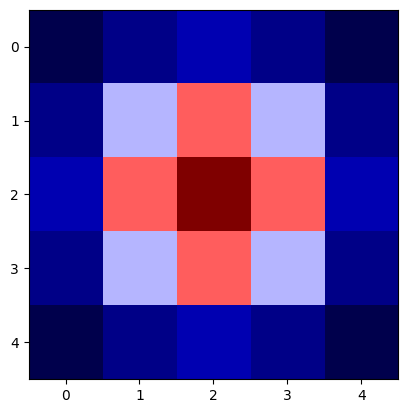

In [3]:
plt.imshow(kernel, cmap='seismic')
plt.show()

Gaussian-Laplacian blending

In [4]:
data_frame = pd.read_csv('train.csv')

In [5]:
# generate mask
a = 512
mask0 = np.zeros((a,a))
mask0[:, int(a/2):] = 255

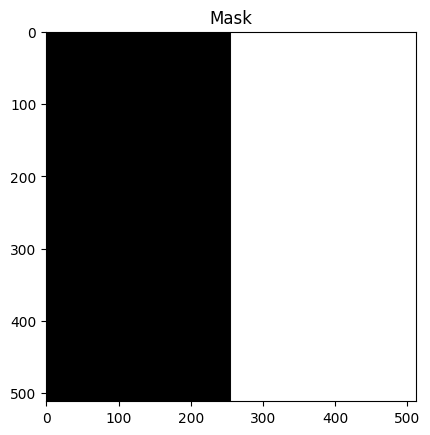

In [6]:
plt.imshow(mask0, cmap='gray')
plt.title('Mask')
plt.show()

In [59]:
import numpy as np
# https://github.com/twyunting/Laplacian-Pyramids


def interpolate(image):
    """
    Interpolates an image with upsampling rate r = 2
    """
    image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
    # Upsample
    image_up[::2, ::2] = image
    # Blur (we need to scale this up since the kernel has unit area)
    # (The length and width are both doubled, so the area is quadrupled)
    # return sig.convolve2d(image_up, 4*kernel, 'same')
    return ndimage.filters.convolve(image_up, 4*kernel, mode='constant')
                                
def decimate(image):
    """
    Decimates an image with downsampling rate r=2.
    """
    image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
    # Downsample
    return image_blur[::2, ::2]                                
               
                                      
# here is the constructions of pyramids
def pyramids(image):
    """
    Constructs Gaussian and Laplacian pyramids.
    Parameters :
    image  : the original image (i.e. base of the pyramid)
    Returns :
    G   : the Gaussian pyramid
    L   : the Laplacian pyramid
    """
    # Initialize pyramids
    G = [image, ]
    L = []

    # Build the Gaussian pyramid to maximum depth
    while image.shape[0] >= 2 and image.shape[1] >= 2:
        image = decimate(image)
        G.append(image)

   # Build the Laplacian pyramid
    for i in range(len(G) - 1):
        L.append(G[i] - interpolate(G[i + 1]))

    return G[:-1], L


# Build Gaussian pyramid and Laplacian pyramids from images A and B, also mask
# Reference: https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f
def pyramidBlending(A, B, mask):
    [GA, LA] = pyramids(A)
    [GB ,LB] = pyramids(B)
    # Build a Gaussian pyramid GR from selected region R (mask that says which pixels come from left and which from right)
    [Gmask, LMask] = pyramids(mask)
    # Form a combined pyramid LS from LA and LB using nodes of GR as weights
    # Equation: LS(i, j) = GR(I, j)*LA(I, j) + (1-GR(I, j)* LB(I, j))
    # Collapse the LS pyramid to get the final blended image
    blend = []
    for i in range(len(LA)):
        # LS = np.max(Gmask[i])*LA[i] + (1-np.max(Gmask[i]))*LB[i]
        # make sure the color with in 255 (white)
        LS = Gmask[i]/255*LA[i] + (1-Gmask[i]/255)*LB[i]
        blend.append(LS)
    return blend

# reconstruct the pyramids as well as upsampling and add up with each level
def reconstruct(pyramid):
    rows, cols = pyramid[0].shape
    res = np.zeros((rows, cols + cols//2), dtype= np.double)
    # start the smallest pyramid so we need to reverse the order
    revPyramid = pyramid[::-1]
    stack = revPyramid[0]
    # start with the second index
    for i in range(1, len(revPyramid)):
        stack = interpolate(stack) + revPyramid[i] # upsampling simultaneously
    return stack
   
# https://compvisionlab.wordpress.com/2013/05/13/image-blending-using-pyramid/
# Besides pyramid Blending, we need to blend image's color
def colorBlending(img1, img2, mask, organ, i=0):
    # split to 3 basic color, then using pyramidBlending and reconstruct it, respectively
    img1R,img1G,img1B = cv2.split(img1)
    img2R,img2G,img2B = cv2.split(img2)
    # reconstruct each color channel and convert to uint8 to return proper img
    R = reconstruct(pyramidBlending(img1R, img2R, mask))
    G = reconstruct(pyramidBlending(img1G, img2G, mask))
    B = reconstruct(pyramidBlending(img1B, img2B, mask))
    output = cv2.merge((R, G, B))#.astype('uint8')
    # imageio.imsave(f"output_{organ}_{i}.png", output)
    # img = cv2.imread(f"output_{organ}_{i}.png")
    # img = imageio.v2.imread("output.png")
    return output
    
def Blending_mask(mask1, mask2, mask0, organ, i=0):
    # # mask2 = mask2.resize(mask1.size)
    # # mask00 = imageio.imsave("output_mask.png", mask0)
    # # mask00 = Image.open("output_mask.png")
    # mask00 = Image.fromarray(mask0)
    # output = Image.composite(mask1, mask2, mask00)
    # # output = output.save(f"output_mask_{organ}_{i}.png")
    # # output = Image.open(f"output_mask_{organ}_{i}.png")
    # return output
    output = mask2
    output[:,256:] = mask1[:,256:]
    return output

def rle2mask(mask_rle, shape=(1600,256)): # decoder
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def read_image_mask(df, img_id):
    # image = imageio.v2.imread(str('train/' f"{img_id}_0000.png"))
    # mask = Image.open(str('masks/' f"{img_id}_0000.png"))
    
    image = tiff.imread(str('train_images/' f"{img_id}.tiff"))
    mask = rle2mask(df[df["id"]==img_id]["rle"].values[0], (image.shape[1], image.shape[0]))

    image = resize(image, (512, 512))
    mask = resize(mask, (512, 512))

    return image, mask

def highlight(row):
    df = lambda x: ['background: #CCCCFF' if x.name in row
                        else '' for i in x]
    return df

def plot_blended_img(img_A, img_B, mask, title, organ):
    plt.figure(figsize=(16,9))
    
    plt.subplot(1,4,1)
    plt.imshow(img_A)
    plt.title('Image A')
    
    plt.subplot(1,4,2)
    plt.imshow(img_B)
    plt.title('Image B')
    
    plt.subplot(1,4,3)
    plt.imshow(mask,cmap='gray')
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    blended_img = colorBlending(img_A, img_B, mask, organ=organ)
    plt.imshow(blended_img)
    plt.title('Blended Image')
    
    plt.suptitle(f'{title}', fontsize=20, y=0.75)
    plt.tight_layout()
    plt.show()
    
def plot_blended_mask(mask_A, mask_B, mask, title, organ):
    plt.figure(figsize=(16,9))
    
    plt.subplot(1,4,1)
    plt.imshow(mask_A)
    plt.title('Mask A')
    
    plt.subplot(1,4,2)
    plt.imshow(mask_B)
    plt.title('Mask B')
    
    plt.subplot(1,4,3)
    plt.imshow(mask,cmap='gray')
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    blended_mask = Blending_mask(mask_A, mask_B, mask, organ=organ )
    plt.imshow(blended_mask)
    plt.title('Blended Mask')
    
    plt.suptitle(f'{title}', fontsize=20, y=0.75)
    plt.tight_layout()
    plt.show()
    
def list_ids_organ(df, o):
    """
    Args: 
        df: dataframe
        o: specific organ 
    
    Returns:
        list_ids: list of ids based on organ
    """
    list_ids = list(df.loc[df['organ']==o].id)
    return list_ids

In [9]:
# create an organ dataframe with ids only
organs = {'prostate': [],'spleen': [],'lung': [],'kidney': [],'largeintestine': []}
for organ, ids in organs.items():
    list_organ = list_ids_organ(data_frame, organ)
    ids.append(list_organ)
df_organs = pd.DataFrame.from_dict(organs, orient='index').reset_index()
df_organs.columns = ['organ', 'ids']

In [ ]:
df_organs.style.hide().apply(highlight([0]), axis=1)

In [25]:
random.seed(10)
random_prostate = random.sample(df_organs.loc[df_organs['organ'] == 'prostate'].ids[0], 2) #.ids[0] -> prostate
img_A, mask_A = read_image_mask(data_frame,random_prostate[0])
img_B, mask_B = read_image_mask(data_frame,random_prostate[1])
img_A.shape, img_B.shape, mask_A.shape, mask_B.shape

((512, 512, 3), (512, 512, 3), (512, 512), (512, 512))

In [22]:
print(image)

None


C:\Users\USER\AppData\Local\Temp\ipykernel_14724\4185872017.py:21: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
C:\Users\USER\AppData\Local\Temp\ipykernel_14724\4185872017.py:15: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  return ndimage.filters.convolve(image_up, 4*kernel, mode='constant')


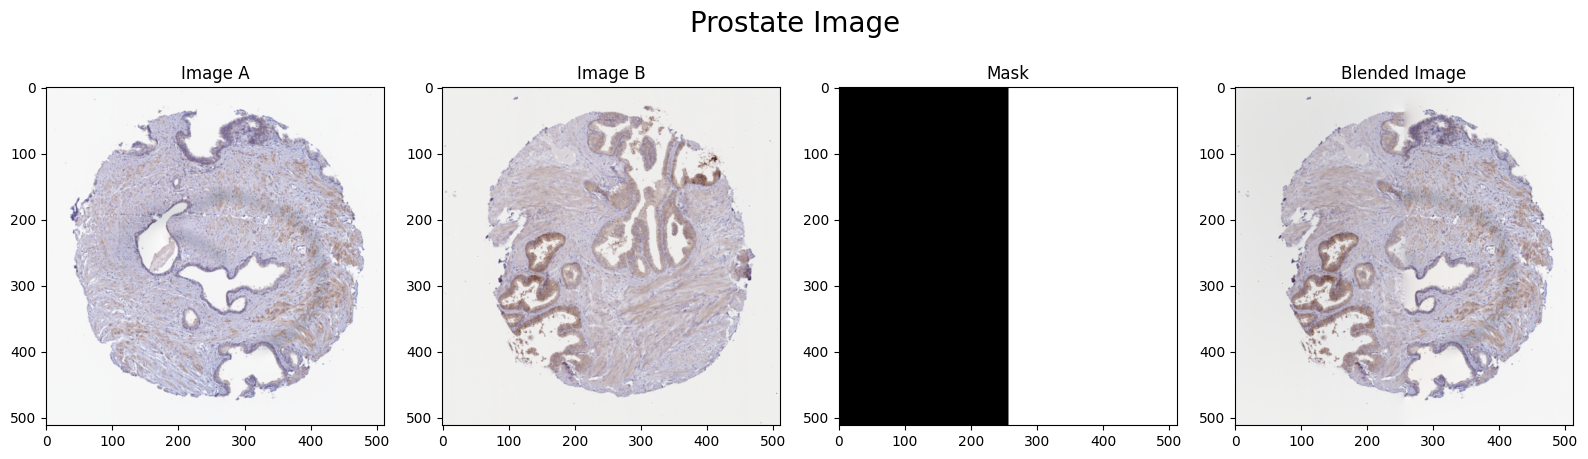

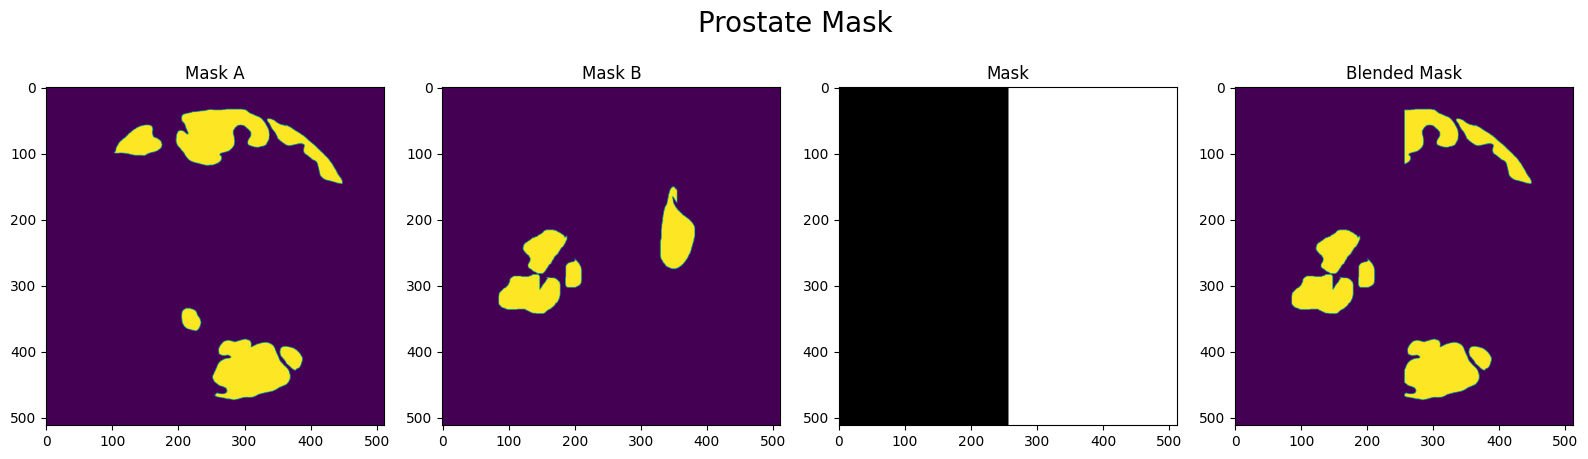

In [60]:
plot_blended_img(img_A, img_B, mask0, 'Prostate Image', 'prostate')
plot_blended_mask(mask_A, mask_B, mask0, 'Prostate Mask', 'prostate')

C:\Users\USER\AppData\Local\Temp\ipykernel_14724\4185872017.py:21: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
C:\Users\USER\AppData\Local\Temp\ipykernel_14724\4185872017.py:15: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  return ndimage.filters.convolve(image_up, 4*kernel, mode='constant')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


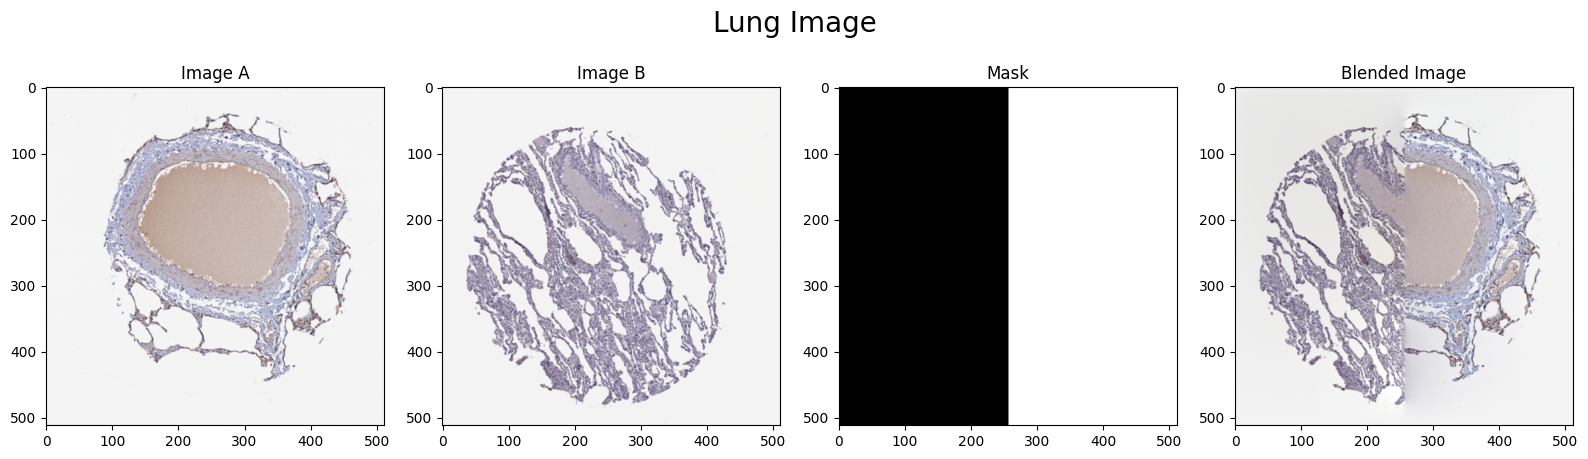

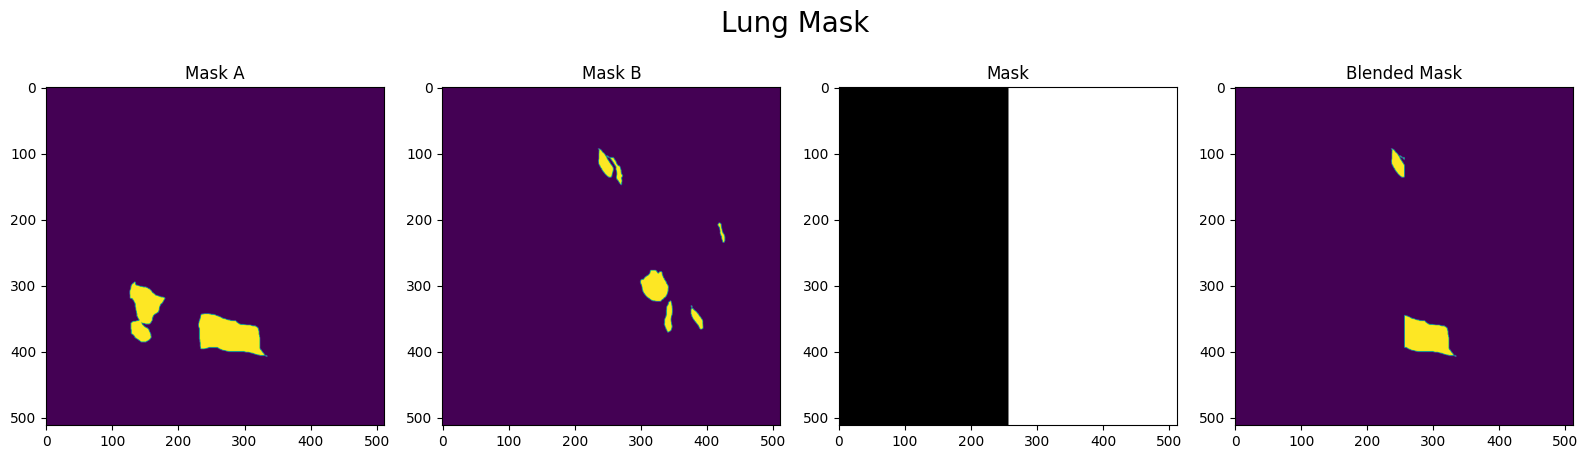

In [61]:
random.seed(10)
random_lung = random.sample(df_organs.loc[df_organs['organ'] == 'lung'].ids[2], 2)
img_A, mask_A = read_image_mask(data_frame,random_lung[0])
img_B, mask_B = read_image_mask(data_frame,random_lung[1])
img_A.shape, img_B.shape, mask_A.size, mask_B.size

plot_blended_img(img_A, img_B, mask0, 'Lung Image', 'lung')
plot_blended_mask(mask_A, mask_B, mask0, 'Lung Mask', 'lung')

C:\Users\USER\AppData\Local\Temp\ipykernel_14724\4185872017.py:21: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
C:\Users\USER\AppData\Local\Temp\ipykernel_14724\4185872017.py:15: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  return ndimage.filters.convolve(image_up, 4*kernel, mode='constant')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


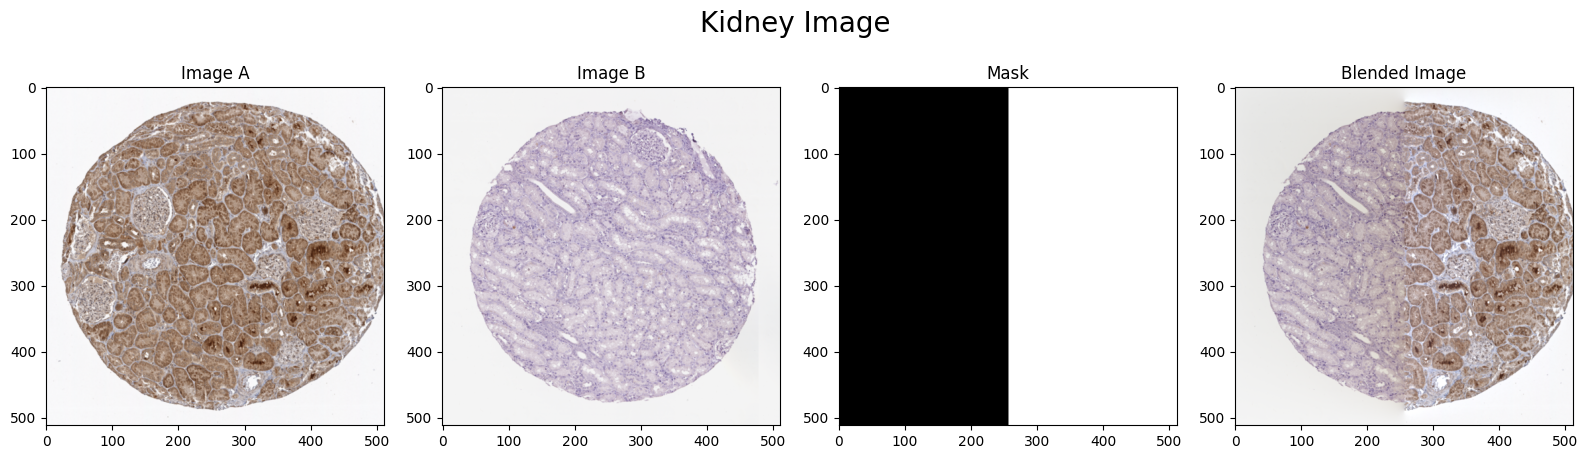

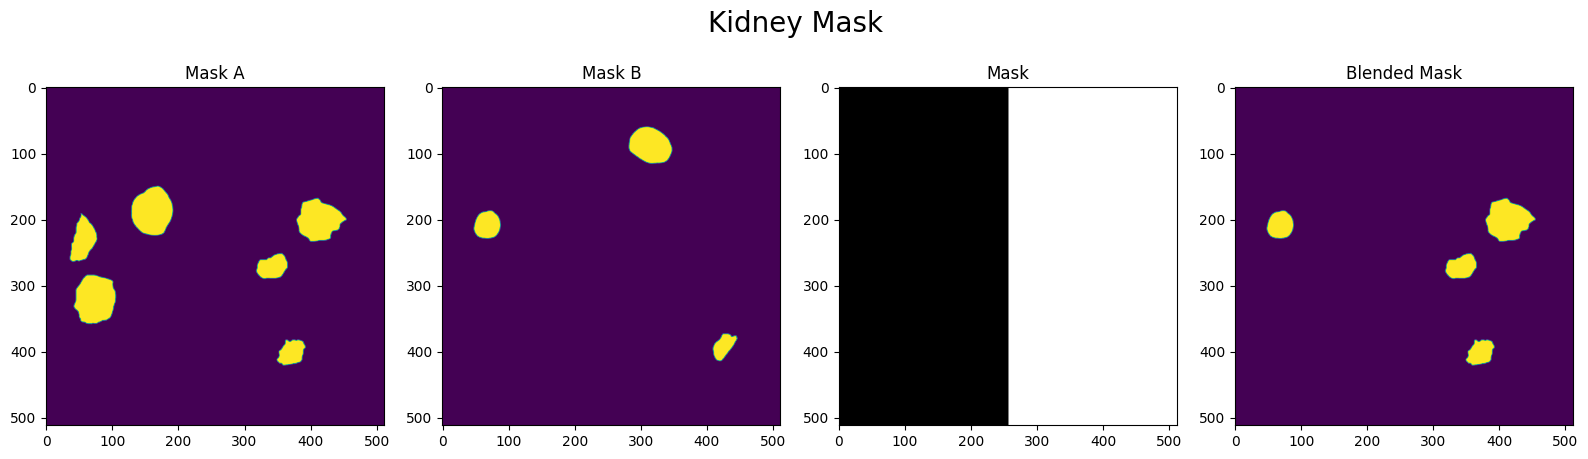

In [62]:
random.seed(10)
random_kidney = random.sample(df_organs.loc[df_organs['organ'] == 'kidney'].ids[3], 2)
img_A, mask_A = read_image_mask(data_frame,random_kidney[0])
img_B, mask_B = read_image_mask(data_frame,random_kidney[1])
img_A.shape, img_B.shape, mask_A.size, mask_B.size

plot_blended_img(img_A, img_B, mask0, 'Kidney Image', 'kidney')
plot_blended_mask(mask_A, mask_B, mask0, 'Kidney Mask', 'kidney')

C:\Users\USER\AppData\Local\Temp\ipykernel_14724\4185872017.py:21: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
C:\Users\USER\AppData\Local\Temp\ipykernel_14724\4185872017.py:15: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  return ndimage.filters.convolve(image_up, 4*kernel, mode='constant')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


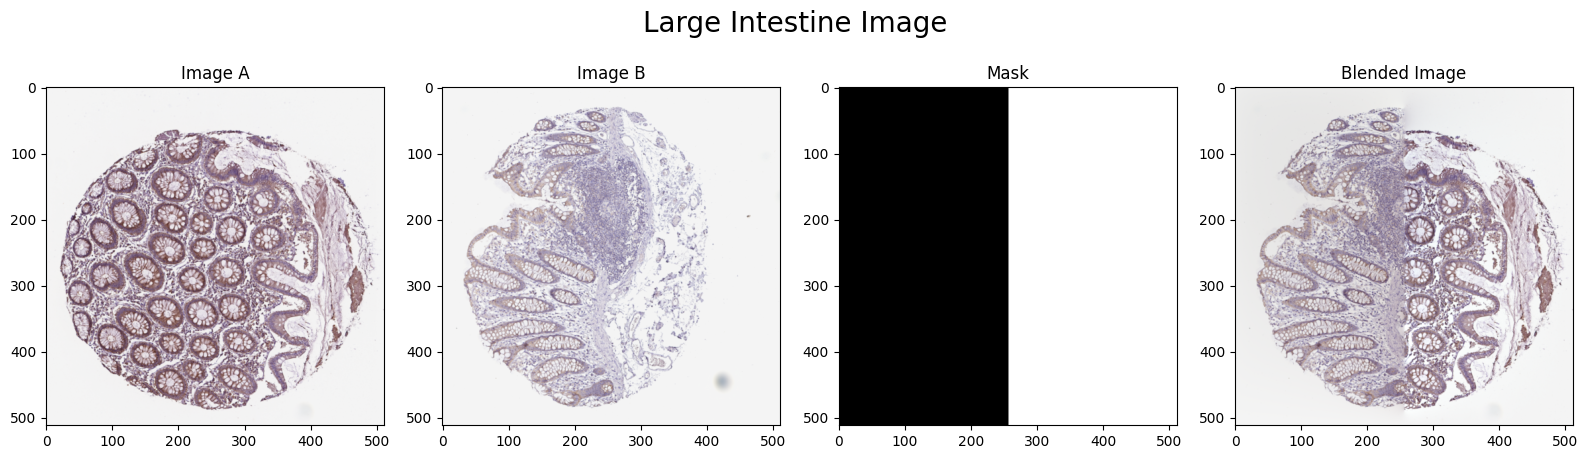

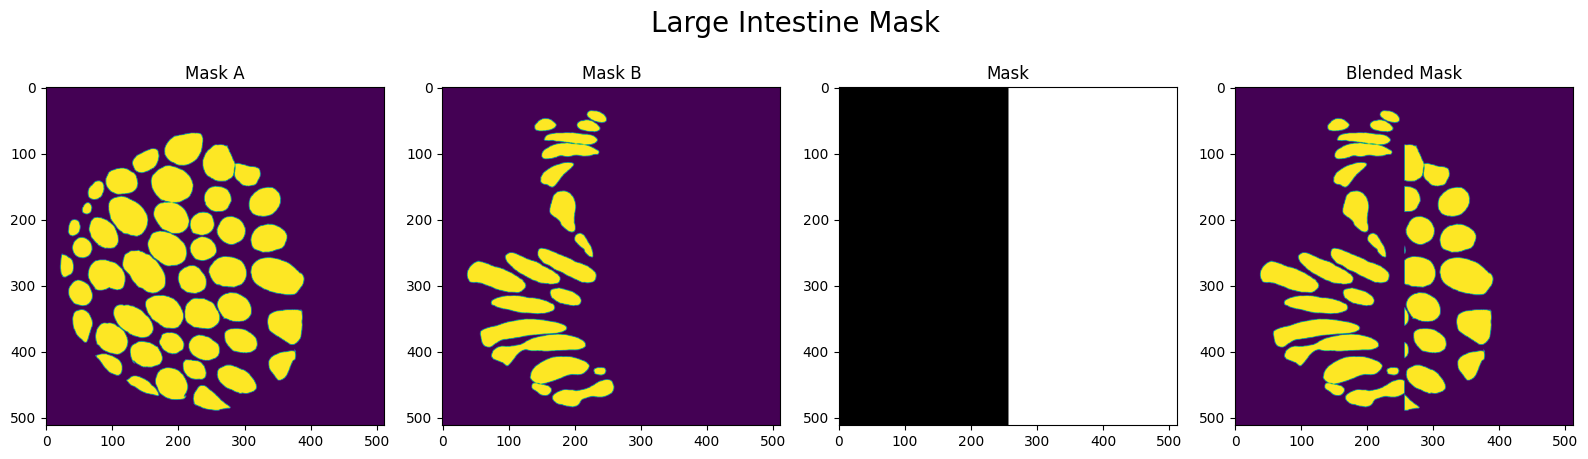

In [63]:
random.seed(10)
random_largeintestine = random.sample(df_organs.loc[df_organs['organ'] == 'largeintestine'].ids[4], 2)
img_A, mask_A = read_image_mask(data_frame,random_largeintestine[0])
img_B, mask_B = read_image_mask(data_frame,random_largeintestine[1])
img_A.shape, img_B.shape, mask_A.size, mask_B.size

plot_blended_img(img_A, img_B, mask0, 'Large Intestine Image', 'largeintestine')
plot_blended_mask(mask_A, mask_B, mask0, 'Large Intestine Mask', 'largeintestine')

In [65]:
a = np.array([[0, 0, 1], [1, 1, 1], [0, 0, 0]])
print(np.count_nonzero(a == 1)/a.size)
a.size

0.4444444444444444


9